# EyeQ - A Quantum Image Foreground/Background Separator
### Table of Contents:
1. Imports
2. Dataset preparation
3. Maximum Cut Algorithm
    - Optional: Brute Force Solution
    - Quantum Algorithm
4. Display Foreground/Background separation

#### Configuration

In [1]:
### UPDATE WITH YOUR RESOURCE ID
azure_resource_id = "/subscriptions/a9532073-d2e5-4738-884c-423cf0336ff5/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/Learn-Quantum"

w_pixels = 3
url = 'https://img.freepik.com/premium-vector/simple-killer-whale-pixel-art-style_475147-1552.jpg?w=1380'
backend_target = "ionq.simulator" # "ionq.qpu.aria-1" or "ionq.simulator"


## 1. Imports
Run pip install commands once in the current environment and then restart the kernel. You can now import necessary packages.

In [2]:
!pip install wget # Used to download image

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... - done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=92a9b64573fcca5624c09fac918d6400ecde089e3753f65a3e33efb99e117425
  Stored in directory: /home/jovyan/.cache/pip/wheels/ba/78/fb/e0c24a9e73d7483b073d15b7e05f43f3fc2ac75eff6899c7aa
Successfully built wget


In [3]:
!pip install qiskit[optimization]

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.2/159.2 kB 6.1 MB/s eta 0:00:00


Set up the provider with your resource ID.

In [2]:
# Set up Provider

from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider (
    resource_id = azure_resource_id,
    location = "westus"
)


In [3]:
# Import packages

from PIL import Image
import wget
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx
import random
import numpy as np

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram

## 2. Dataset Preparation
Images are acquired from online and resized to fit the qubit capacity.

#### Crop and resize image

Original image:


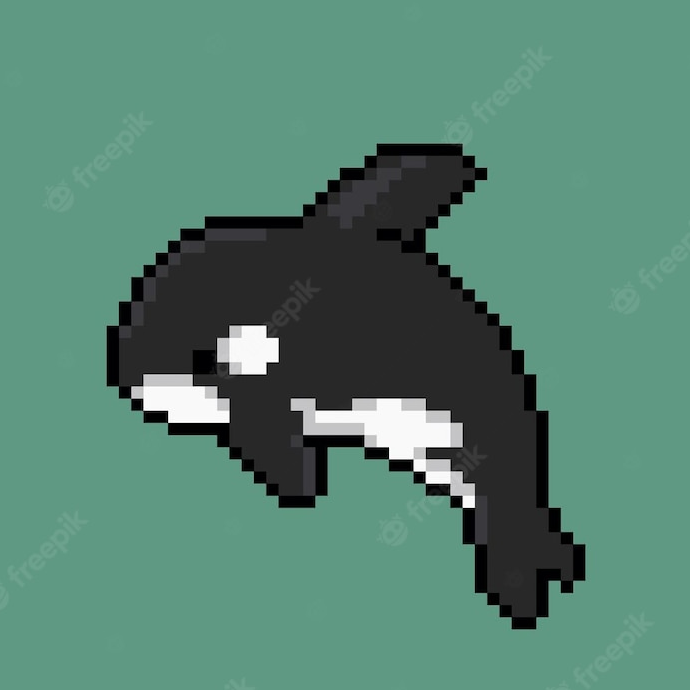

/tmp/ipykernel_22390/1228886688.py:18: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  small_img=img.resize((w_pixels,w_pixels),Image.BILINEAR)
/tmp/ipykernel_22390/1228886688.py:22: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  res=small_img.resize(o_size,Image.NEAREST)


Text(0.5, 1.0, 'Image reduced to 3 by 3 pixels')

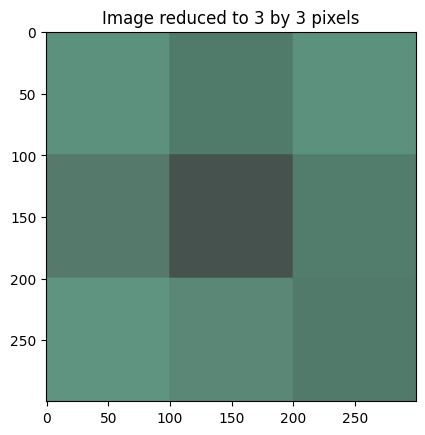

In [4]:
n = w_pixels**2

# Fetch image
response = requests.get(url)
img = Image.open(BytesIO(response.content))

width, height = img.size
# Crop image
left = width/4
top = height / 4
right = 3 * width/4
bottom = 3 * height / 4
img = img.crop((left, top, right, bottom))
print("Original image:")
img.show(title="Original Image")

# Resize image
small_img=img.resize((w_pixels,w_pixels),Image.BILINEAR)

# Display the reduced image zoomed in so that we can see it
o_size=(300,300)
res=small_img.resize(o_size,Image.NEAREST)
plt.imshow(res)
title = "Image reduced to " + str(w_pixels) + " by " + str(w_pixels) + " pixels"
plt.title(title)


#### Compute color similarities between every pixel
To distinguish the foreground from the background of the image, we have decided to base our approximations on the colors of the pixels, because we will assume that the background should be more or less the same color. Thus, we will represent a graph where every node represents a pixel, and every edge weight represents how close a pixel pair's RGB values are.

In [5]:
# Convert each pixel to a node
nodes = np.asarray(small_img)

# Flatten the width and height of the matrix. Preserve channels.
nodes = nodes.reshape(nodes.shape[0]*nodes.shape[1],nodes.shape[2])
print("Matrix dimensions: ", nodes.shape)

elist = [] # List of edges. Each edge is a tuple in the format (Point A, Point B, Similarity)

# Get edge weights in between every pixel in each channel
for a in range(nodes.shape[0]):
    for b in range(a+1, nodes.shape[0]):
        total_diff = 0 # across all channels
        for channel in range(nodes.shape[1]):
            color_node1 = nodes[a, channel]
            color_node2 = nodes[b, channel]
            diff = abs(int(color_node1)-int(color_node2))
            total_diff += diff
        weight = total_diff
        edge = (a, b, weight)
        elist.append(edge)


elist

Matrix dimensions:  (9, 3)


[(0, 1, 51),
 (0, 2, 0),
 (0, 3, 48),
 (0, 4, 131),
 (0, 5, 47),
 (0, 6, 11),
 (0, 7, 17),
 (0, 8, 52),
 (1, 2, 51),
 (1, 3, 7),
 (1, 4, 80),
 (1, 5, 4),
 (1, 6, 62),
 (1, 7, 34),
 (1, 8, 3),
 (2, 3, 48),
 (2, 4, 131),
 (2, 5, 47),
 (2, 6, 11),
 (2, 7, 17),
 (2, 8, 52),
 (3, 4, 83),
 (3, 5, 7),
 (3, 6, 59),
 (3, 7, 31),
 (3, 8, 6),
 (4, 5, 84),
 (4, 6, 142),
 (4, 7, 114),
 (4, 8, 79),
 (5, 6, 58),
 (5, 7, 30),
 (5, 8, 5),
 (6, 7, 28),
 (6, 8, 63),
 (7, 8, 35)]

#### Build graph from pixel relationships

[[  0.  51.   0.  48. 131.  47.  11.  17.  52.]
 [ 51.   0.  51.   7.  80.   4.  62.  34.   3.]
 [  0.  51.   0.  48. 131.  47.  11.  17.  52.]
 [ 48.   7.  48.   0.  83.   7.  59.  31.   6.]
 [131.  80. 131.  83.   0.  84. 142. 114.  79.]
 [ 47.   4.  47.   7.  84.   0.  58.  30.   5.]
 [ 11.  62.  11.  59. 142.  58.   0.  28.  63.]
 [ 17.  34.  17.  31. 114.  30.  28.   0.  35.]
 [ 52.   3.  52.   6.  79.   5.  63.  35.   0.]]


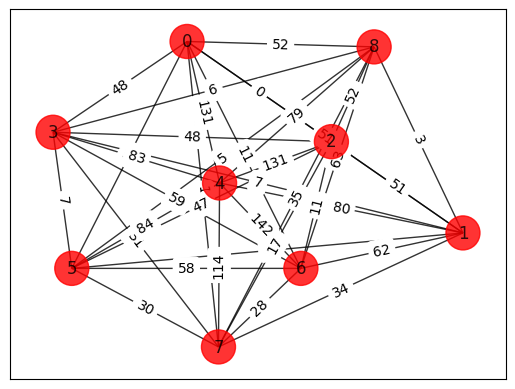

In [6]:
# Taken from https://qiskit.org/documentation/optimization/tutorials/06_examples_max_cut_and_tsp.html

G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
G.add_weighted_edges_from(elist)


colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

# Computing the weight matrix from the graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)



## 2. Max Cut Algorithm
#### (Optional) Brute Force Classical Solution
Here is the classical solution to the max-cut problem. We provided it as a sanity check to see how well the quantum solution measures up.


Best solution = [0, 0, 1, 0] cost = 72.0
Problem name: Max-cut

Maximize
  -6*x_0*x_1 - 42*x_0*x_2 - 24*x_0*x_3 - 36*x_1*x_2 - 30*x_1*x_3 - 66*x_2*x_3
  + 36*x_0 + 36*x_1 + 72*x_2 + 60*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



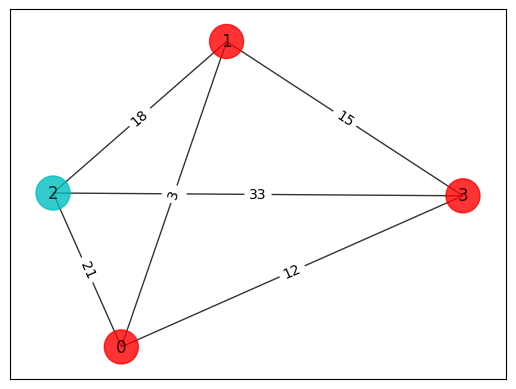

In [7]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    #print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())


#### Classical Solution

Offset: -51.0
Ising Hamiltonian:
1.5 * IIZZ
+ 10.5 * IZIZ
+ 9.0 * IZZI
+ 6.0 * ZIIZ
+ 7.5 * ZIZI
+ 16.5 * ZZII
objective function value: 72.0
variable values: x_0=0.0, x_1=0.0, x_2=1.0, x_3=0.0
status: SUCCESS
energy: -21.0
max-cut objective: -72.0
solution: [0 0 1 0]
solution objective: 72.0


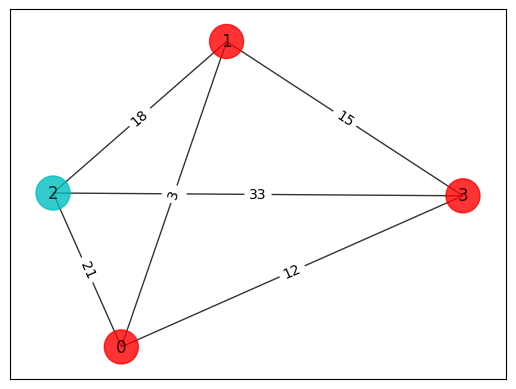

In [8]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())


# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)


End of optional section.
#### Quantum Solution

In [7]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()

qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

algorithm_globals.random_seed = 123
seed = 10598

ionq_qpu_backend = provider.get_backend(backend_target)
quantum_instance = QuantumInstance(ionq_qpu_backend, shots=500)

# construct VQE
spsa = SPSA(maxiter=10)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

Offset: -864.0
Ising Hamiltonian:
25.5 * IIIIIIIZZ
+ 25.5 * IIIIIIZZI
+ 24.0 * IIIIIZIIZ
+ 3.5 * IIIIIZIZI
+ 24.0 * IIIIIZZII
+ 65.5 * IIIIZIIIZ
+ 40.0 * IIIIZIIZI
+ 65.5 * IIIIZIZII
+ 41.5 * IIIIZZIII
+ 23.5 * IIIZIIIIZ
+ 2.0 * IIIZIIIZI
+ 23.5 * IIIZIIZII
+ 3.5 * IIIZIZIII
+ 42.0 * IIIZZIIII
+ 5.5 * IIZIIIIIZ
+ 31.0 * IIZIIIIZI
+ 5.5 * IIZIIIZII
+ 29.5 * IIZIIZIII
+ 71.0 * IIZIZIIII
+ 29.0 * IIZZIIIII
+ 8.5 * IZIIIIIIZ
+ 17.0 * IZIIIIIZI
+ 8.5 * IZIIIIZII
+ 15.5 * IZIIIZIII
+ 57.0 * IZIIZIIII
+ 15.0 * IZIZIIIII
+ 14.0 * IZZIIIIII
+ 26.0 * ZIIIIIIIZ
+ 1.5 * ZIIIIIIZI
+ 26.0 * ZIIIIIZII
+ 3.0 * ZIIIIZIII
+ 39.5 * ZIIIZIIII
+ 2.5 * ZIIZIIIII
+ 31.5 * ZIZIIIIII
+ 17.5 * ZZIIIIIII
.........................................................................................................................................................................................................................................................................................................................

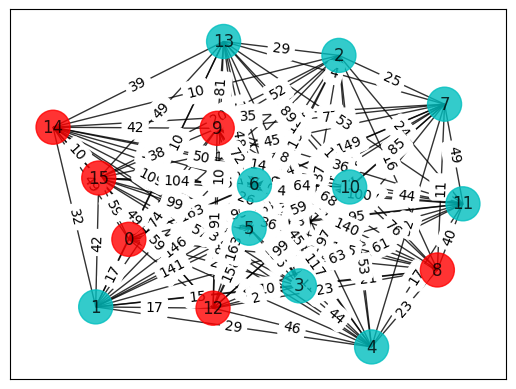

In [21]:
# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

## Display Background/Foreground Separation

/tmp/ipykernel_22390/1630670405.py:18: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img=img.resize(o_size,Image.NEAREST)


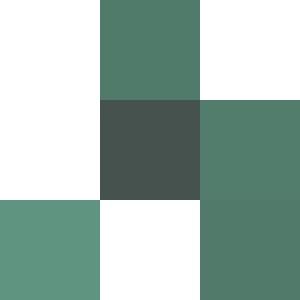

/tmp/ipykernel_22390/1630670405.py:22: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img=img.resize(o_size,Image.NEAREST)


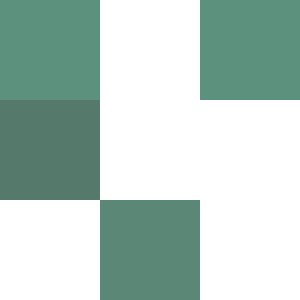

In [8]:
bits = list(x)
small_img.putalpha(255)

counter = 0
nodes = np.asarray(small_img)
zero = nodes.copy()
one = nodes.copy()

for x1 in range(nodes.shape[1]):
    for y1 in range(nodes.shape[0]):
        if bits[counter] == 0:
            zero[x1, y1, 3] = 0
        else:
            one[x1, y1, 3] = 0
        counter += 1

img = Image.fromarray(zero)
img=img.resize(o_size,Image.NEAREST)
img.show()

img = Image.fromarray(one)
img=img.resize(o_size,Image.NEAREST)
img.show()